<a href="https://colab.research.google.com/github/eghib22/I-m-Something-of-a-Painter-Myself/blob/main/cyclegan_resnet_vs_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install kaggle
! pip install wandb
import wandb
wandb.login(key="3a8d716177f04f9862b6cefb18e6d97955122204")
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
DRIVE_KAGGLE_PATH = '/content/drive/MyDrive/kaggle.json'

! mkdir -p ~/.kaggle
! cp "{DRIVE_KAGGLE_PATH}" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!ls -l ~/.kaggle/
!kaggle competitions download -c gan-getting-started
!unzip -o -q gan-getting-started.zip -d data
!ls data
import os
import random
import itertools
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: eghib22 (eghib22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Mounted at /content/drive
total 4
-rw------- 1 root root 74 Jan 17 19:41 kaggle.json
 87% 321M/367M [00:00<00:00, 471MB/s]
100% 367M/367M [00:00<00:00, 463MB/s]
monet_jpg  monet_tfrec	photo_jpg  photo_tfrec


In [2]:
class Config:
    generator_type = "resnet"  # or "unet"
    image_size = 256
    batch_size = 1
    num_workers = 2
    lr = 2e-4
    epochs = 40
    lambda_cycle = 10.0
    lambda_identity = 5.0
    device = "cuda" if torch.cuda.is_available() else "cpu"

cfg = Config()

class MonetPhotoDataset(Dataset):
    def __init__(self, monet_dir, photo_dir, transform=None):
        self.monet_paths = sorted(os.listdir(monet_dir))
        self.photo_paths = sorted(os.listdir(photo_dir))
        self.monet_dir = monet_dir
        self.photo_dir = photo_dir
        self.transform = transform

    def __len__(self):
        return len(self.monet_paths)


    def __getitem__(self, idx):
        monet_path = os.path.join(
            self.monet_dir,
            self.monet_paths[idx % len(self.monet_paths)]
        )
        photo_path = os.path.join(
            self.photo_dir,
            self.photo_paths[random.randint(0, len(self.photo_paths) - 1)]
        )

        monet = Image.open(monet_path).convert("RGB")
        photo = Image.open(photo_path).convert("RGB")

        if self.transform:
            monet = self.transform(monet)
            photo = self.transform(photo)

        return {"monet": monet, "photo": photo}


transform = transforms.Compose([
    transforms.Resize(286),
    transforms.RandomCrop(cfg.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = MonetPhotoDataset(
    "data/monet_jpg",
    "data/photo_jpg",
    transform
)

loader = DataLoader(
    dataset,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers
)
fixed_batch = next(iter(loader))
fixed_photo = fixed_batch["photo"].to(cfg.device)

In [9]:
@torch.no_grad()
def save_samples(epoch):
    G.eval()
    # fixed_photo was already moved to device in cell O6kjznkfGM29
    # fixed_photo has shape [batch_size, channels, height, width]
    # We want to show the first 4 real photos and their generated Monet versions.
    real_photos_to_display = fixed_photo[:4]
    fake_monets_to_display = G(real_photos_to_display) # Generate from the same real photos

    # Concatenate real photos and fake monets vertically for display
    # This will result in 4 real photos on the top row and 4 fake monets on the bottom row
    combined_images = torch.cat([real_photos_to_display, fake_monets_to_display], dim=0)

    grid = make_grid(combined_images, nrow=4, normalize=True) # 4 images per row
    plt.figure(figsize=(8, 6)) # Adjust figure size for two rows
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(f"Epoch {epoch}")
    plt.show()
    G.train()
    return grid
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, n_blocks=9):
        super().__init__()

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(True)
        ]

        # Downsample
        in_features = 64
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, in_features * 2, 3, stride=2, padding=1),
                nn.InstanceNorm2d(in_features * 2),
                nn.ReLU(True)
            ]
            in_features *= 2

        # Residual blocks
        for _ in range(n_blocks):
            model += [ResnetBlock(in_features)]

        # Upsample
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, in_features // 2, 3, stride=2,
                                   padding=1, output_padding=1),
                nn.InstanceNorm2d(in_features // 2),
                nn.ReLU(True)
            ]
            in_features //= 2

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, output_nc, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(out_c),
                nn.LeakyReLU(0.2, True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
                nn.InstanceNorm2d(out_c),
                nn.ReLU(True)
            )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        return self.dropout(x) if self.use_dropout else x

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.d1 = nn.Conv2d(in_channels, 64, 4, 2, 1)
        self.d2 = UNetBlock(64, 128, down=True)
        self.d3 = UNetBlock(128, 256, down=True)
        self.d4 = UNetBlock(256, 512, down=True)
        self.d5 = UNetBlock(512, 512, down=True)

        self.u1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.u2 = UNetBlock(1024, 256, down=False, use_dropout=True)
        self.u3 = UNetBlock(512, 128, down=False)
        self.u4 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.d1(x)
        d2 = self.d2(d1)
        d3 = self.d3(d2)
        d4 = self.d4(d3)
        d5 = self.d5(d4)

        u1 = self.u1(d5)
        u2 = self.u2(torch.cat([u1, d4], 1))
        u3 = self.u3(torch.cat([u2, d3], 1))
        u4 = self.u4(torch.cat([u3, d2], 1))

        return self.final(torch.cat([u4, d1], 1))

In [5]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_nc=3):
        super().__init__()

        def block(in_c, out_c, stride=2, norm=True):
            layers = [nn.Conv2d(in_c, out_c, 4, stride=stride, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, True))
            return layers

        self.model = nn.Sequential(
            *block(input_nc, 64, norm=False),
            *block(64, 128),
            *block(128, 256),
            *block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)
class LSGANLoss:
    def __init__(self):
        self.loss = nn.MSELoss()

    def __call__(self, preds, target_is_real):
        if target_is_real:
            target = torch.ones_like(preds)
        else:
            target = torch.zeros_like(preds)
        return self.loss(preds, target)
cycle_loss_fn = nn.L1Loss()
identity_loss_fn = nn.L1Loss()
gan_loss_fn = LSGANLoss()

if cfg.generator_type == "resnet":
    G = ResnetGenerator().to(cfg.device)
    F = ResnetGenerator().to(cfg.device)
elif cfg.generator_type == "unet":
    G = UNetGenerator().to(cfg.device)
    F = UNetGenerator().to(cfg.device)

D_monet = PatchDiscriminator().to(cfg.device)
D_photo = PatchDiscriminator().to(cfg.device)
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.InstanceNorm2d):
        if m.weight is not None:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

G.apply(init_weights)
F.apply(init_weights)
D_monet.apply(init_weights)
D_photo.apply(init_weights)


PatchDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [6]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch = 0

g_path = os.path.join(checkpoint_dir, "G_latest.pth")
f_path = os.path.join(checkpoint_dir, "F_latest.pth")

if os.path.exists(g_path) and os.path.exists(f_path):
    print("🔁 Resuming from latest checkpoint")
    G.load_state_dict(torch.load(g_path, map_location=cfg.device), strict=False)
    F.load_state_dict(torch.load(f_path, map_location=cfg.device), strict=False)
class ImagePool:
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.images = []

    def query(self, images):
        result = []
        for image in images:
            image = image.unsqueeze(0)
            if len(self.images) < self.pool_size:
                self.images.append(image)
                result.append(image)
            else:
                if random.random() > 0.5:
                    idx = random.randint(0, self.pool_size - 1)
                    tmp = self.images[idx].clone()
                    self.images[idx] = image
                    result.append(tmp)
                else:
                    result.append(image)
        return torch.cat(result, dim=0)

fake_monet_pool = ImagePool(50)
fake_photo_pool = ImagePool(50)


🔁 Resuming from latest checkpoint


epoch,▁▁▁
loss_D_monet,█▂▁
loss_D_photo,█▁▁
loss_G,█▁▅
loss_cycle,▁▁█
loss_identity,▃▁█
step,▁▅█
epoch,0
loss_D_monet,0.33232
loss_D_photo,0.2821
loss_G,6.67762



🚀 Starting epoch 1/40
[Epoch 1/40] [Batch 0/300] G: 4.393 | Cycle: 2.440 | Id: 1.241 | D_M: 0.238 | D_P: 0.341
[Epoch 1/40] [Batch 100/300] G: 4.082 | Cycle: 2.333 | Id: 0.973 | D_M: 0.259 | D_P: 0.433
[Epoch 1/40] [Batch 200/300] G: 5.321 | Cycle: 3.185 | Id: 1.234 | D_M: 0.208 | D_P: 0.116


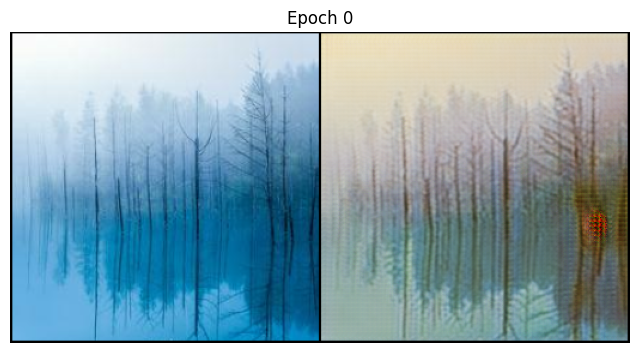


🚀 Starting epoch 2/40
[Epoch 2/40] [Batch 0/300] G: 5.513 | Cycle: 3.260 | Id: 1.635 | D_M: 0.290 | D_P: 0.202
[Epoch 2/40] [Batch 100/300] G: 6.060 | Cycle: 3.924 | Id: 1.394 | D_M: 0.431 | D_P: 0.273
[Epoch 2/40] [Batch 200/300] G: 4.256 | Cycle: 2.656 | Id: 1.177 | D_M: 0.224 | D_P: 0.346


In [ ]:
num_batches = len(loader)

# Define Optimizers
g_optimizer = torch.optim.Adam(itertools.chain(G.parameters(), F.parameters()), lr=cfg.lr, betas=(0.5, 0.999))
d_monet_optimizer = torch.optim.Adam(D_monet.parameters(), lr=cfg.lr, betas=(0.5, 0.999))
d_photo_optimizer = torch.optim.Adam(D_photo.parameters(), lr=cfg.lr, betas=(0.5, 0.999))

wandb.init(project="cyclegan_monet_photos", config=cfg)

for epoch in range(cfg.epochs):
    print(f"\n🚀 Starting epoch {epoch+1}/{cfg.epochs}")

    for i, batch in enumerate(loader):
        real_monet = batch["monet"].to(cfg.device)
        real_photo = batch["photo"].to(cfg.device)

        # =========================
        # Train Generators
        # =========================
        g_optimizer.zero_grad()

        fake_monet = G(real_photo)
        rec_photo = F(fake_monet)

        fake_photo = F(real_monet)
        rec_monet = G(fake_photo)

        loss_g_photo = gan_loss_fn(D_monet(fake_monet), True)
        loss_g_monet = gan_loss_fn(D_photo(fake_photo), True)

        loss_cycle = (
            cycle_loss_fn(rec_photo, real_photo) +
            cycle_loss_fn(rec_monet, real_monet)
        ) * cfg.lambda_cycle

        id_photo = F(real_photo)
        id_monet = G(real_monet)

        loss_identity = (
            identity_loss_fn(id_photo, real_photo) +
            identity_loss_fn(id_monet, real_monet)
        ) * cfg.lambda_identity

        loss_G = loss_g_photo + loss_g_monet + loss_cycle + loss_identity
        loss_G.backward()
        g_optimizer.step()

        # =========================
        # Train Discriminator Monet
        # =========================
        d_monet_optimizer.zero_grad()

        loss_d_monet_real = gan_loss_fn(D_monet(real_monet), True)
        fake_monet_buffer = fake_monet_pool.query(fake_monet.detach())
        loss_d_monet_fake = gan_loss_fn(D_monet(fake_monet_buffer), False)

        loss_D_monet = (loss_d_monet_real + loss_d_monet_fake) * 0.5

        loss_D_monet.backward()
        d_monet_optimizer.step()

        # =========================
        # Train Discriminator Photo
        # =========================
        d_photo_optimizer.zero_grad()

        loss_d_photo_real = gan_loss_fn(D_photo(real_photo), True)
        fake_photo_buffer = fake_photo_pool.query(fake_photo.detach())
        loss_d_photo_fake = gan_loss_fn(D_photo(fake_photo_buffer), False)

        loss_D_photo = (loss_d_photo_real + loss_d_photo_fake) * 0.5

        loss_D_photo.backward()
        d_photo_optimizer.step()

        # =========================
        # Logging + PRINTS
        # =========================
        if i % 100 == 0:
            print(
                f"[Epoch {epoch+1}/{cfg.epochs}] "
                f"[Batch {i}/{num_batches}] "
                f"G: {loss_G.item():.3f} | "
                f"Cycle: {loss_cycle.item():.3f} | "
                f"Id: {loss_identity.item():.3f} | "
                f"D_M: {loss_D_monet.item():.3f} | "
                f"D_P: {loss_D_photo.item():.3f}"
            )

            wandb.log({
                "loss_G": loss_G.item(),
                "loss_cycle": loss_cycle.item(),
                "loss_identity": loss_identity.item(),
                "loss_D_monet": loss_D_monet.item(),
                "loss_D_photo": loss_D_photo.item(),
                "epoch": epoch,
                "step": epoch * num_batches + i
            })
    image_grid_for_wandb = save_samples(epoch)
    torch.save(G.state_dict(), f"{checkpoint_dir}/G_latest.pth")
    torch.save(F.state_dict(), f"{checkpoint_dir}/F_latest.pth")
    wandb.log({
      "epoch": epoch,
      "generated_samples_grid": wandb.Image(image_grid_for_wandb)
  })

wandb.finish()